# Extract Structured Information from Case Texts
A sample of 10k files across different years and High Courts is used to create functions and processes to extract information. Helper functions are written in Pycharm and imported.

In [48]:
import os 
import sys
import re
import time
import csv
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import ik_parsing as ik
import data_extraction as de
import helper_functions as hp
import defs
from datetime import datetime
from collections import defaultdict
import itertools
import zipfile
import gzip
import json
import concurrent.futures
from multiprocessing import Pool
import matplotlib.pyplot as plt

head, tail = os.path.split(os.getcwd())

## 2. Extracting Structured Information from Case Text
Similar to what we did with the more structured Guwahati HC data, we now try to parse important information such as judge names, case types, names of litigants etc from the case text. It is incredibly hard due to different courts having different formats that also change with time.

Import a list of banks from a RBI linked website. This seems like an exhaustive list of ~160 banks in India.

### With Multiprocessing

In [5]:
import importlib
importlib.reload(ik)
importlib.reload(de)


if __name__ == '__main__':
    start = time.time()
    df = pd.DataFrame()
    courts = ['bombay', 'jharkhand', 'chattisgarh', 'jammu', 'andhra']
    dfs = []
#     pool = Pool()
#     results = pool.imap(de.extract_data, courts)      
                
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(de.extract_data, courts)

    for result in results:
        dfs.append(pd.DataFrame(result))

df = pd.concat(dfs)

# takes ~1506 seconds with 500 limit break; took ~3 hours or so for all of MH, JH and CH
print(f"--- {(time.time() - start)} seconds ---")  

print(df.shape)
df.head()

--- 34062.94619631767 seconds ---
(624453, 13)


,file,cnr_num,title,date,court,case_number,petitioner,respondent,petitioner_advocate,respondent_advocate,judge,banks,citations
0,bombay/2000/1001219.txt,NaN,Smt. Kamalabai Baburao Kabade vs Smt. Laxmibai...,2000-06-16,Bombay High Court,NaN,NaN,NaN,NaN,NaN,{A Khanwilkar},NaN,"{1001219, 173132957, 1630779, 135316600, 26690..."
1,bombay/2000/1004863.txt,NaN,Shri Vasant Devlal Bhavsar vs Bar Council Of M...,2000-07-19,Bombay High Court,2. one smt. s.v. vaishnav has lodged a complai...,NaN,NaN,NaN,NaN,"{A Shah, B Marlapalle}",NaN,"{1426050, 200474, 1439330, 1004863, 818009}"
2,bombay/2000/1007060.txt,NaN,Chandrakant Bhalchandra Garware vs Anil Prabha...,2000-02-09,Bombay High Court,the record and proceedings of the lower court ...,NaN,NaN,NaN,NaN,{D Deshpande},NaN,"{1227984, 1326950, 43650, 1915814, 103053, 105..."
3,bombay/2000/1007895.txt,NaN,Trimbak S/O Waluba Sonwane vs The State Of Mah...,2000-02-29,Bombay High Court,2. crime no. 143/96 came to be registered agai...,NaN,NaN,NaN,NaN,"{B Marlapalle, D Zoting}",NaN,"{1039892, 1712542, 1543073, 11461, 1007895, 12..."
4,bombay/2000/1011986.txt,NaN,Safruddin Abdul Majid Khan vs Mr. R.H. Mendonc...,2000-04-24,Bombay High Court,NaN,NaN,NaN,NaN,NaN,"{V Sahai, Kakade}",NaN,"{752609, 1011986, 966422, 222396, 1636171, 313..."


In [185]:
df.reset_index(drop=True, inplace=True)
df['case_id'] = df['file'].apply(lambda x: x[x.rfind('/')+1:-4]) 

citation_counts = hp.citation_count_dict(df)

df['times_cited'] = df['case_id'].apply(lambda x: citation_counts.get(x, 0))

df['bench_size'] = df.loc[:,'judge'].dropna().apply(len)
        
df['num_citations'] = df.loc[:,'citations'].dropna().apply(len)

df['chief_justice'] = df.loc[:,'judge'].dropna().apply(lambda x: (any('chief' in item for item in x)))

keywords_state = ['state', 'government', 'commissioner', 'national', 'india', 'indian', 'public', 'magistrate',
                  'collector', 'department', 'district']
df['state'] = df.loc[:,'title'].dropna().apply(lambda x: (any(keyword in x.lower() for keyword in keywords_state)))

keywords_business = ['pvt', 'private', 'limited', 'ltd', 'company', 'co.', 'llp', 'llc']
df['business'] = (df.loc[:,'petitioner']+df.loc[:,'respondent']).dropna().apply(lambda x: (any(keyword in x.lower() for keyword in keywords_business)))

keywords_male = ['shri', 'mr.', 'master']

df.replace('\n', ' ', regex = True, inplace = True)
print(df.shape)
df.head()

(970801, 20)


,file,cnr_num,title,date,court,case_number,petitioner,respondent,petitioner_advocate,respondent_advocate,judge,banks,citations,bench_size,num_citations,chief_justice,state,business,case_id,times_cited
0,bombay/2000/1001219.txt,NaN,Smt. Kamalabai Baburao Kabade vs Smt. Laxmibai...,2000-06-16,Bombay High Court,NaN,NaN,NaN,NaN,NaN,{A Khanwilkar},NaN,"{1630779, 1331149, 1108515, 135316600, 1412634...",1.0,7.0,False,False,NaN,1001219,6
1,bombay/2000/1004863.txt,NaN,Shri Vasant Devlal Bhavsar vs Bar Council Of M...,2000-07-19,Bombay High Court,2. one smt. s.v. vaishnav has lodged a complai...,NaN,NaN,NaN,NaN,"{A Shah, B Marlapalle}",NaN,"{818009, 1439330, 1426050, 200474}",1.0,4.0,False,False,NaN,1004863,0
2,bombay/2000/1007060.txt,NaN,Chandrakant Bhalchandra Garware vs Anil Prabha...,2000-02-09,Bombay High Court,the record and proceedings of the lower court ...,NaN,NaN,NaN,NaN,{D Deshpande},NaN,"{1953529, 487818, 1038208, 1326950, 1227984, 1...",1.0,16.0,False,False,NaN,1007060,0
3,bombay/2000/1007895.txt,NaN,Trimbak S/O Waluba Sonwane vs The State Of Mah...,2000-02-29,Bombay High Court,2. crime no. 143/96 came to be registered agai...,NaN,NaN,NaN,NaN,"{B Marlapalle, D Zoting}",NaN,"{142278, 11461, 1228265, 1290514, 1712542, 119...",1.0,12.0,False,True,NaN,1007895,0
4,bombay/2000/1011986.txt,NaN,Safruddin Abdul Majid Khan vs Mr. R.H. Mendonc...,2000-04-24,Bombay High Court,NaN,NaN,NaN,NaN,NaN,"{V Sahai, Kakade}",NaN,"{915147, 1712542, 752609, 578299, 16008, 21227...",1.0,15.0,False,True,NaN,1011986,3


In [189]:
df.isna().sum()

file                        0
cnr_num                915071
title                    7160
date                     7160
court                    7160
case_number            755349
petitioner             461283
respondent             461283
petitioner_advocate    891544
respondent_advocate    913377
judge                   38775
banks                  946423
citations              190582
bench_size              38775
num_citations          190582
chief_justice           38775
state                    7160
business               461283
case_id                     0
times_cited                 0
dtype: int64

The number of missing values. Try and get this to around 85-90% and above to proceed. Judges we are extracting at a reasonable accuracy. Next step is to optimize advocates but that is a lot more difficult. Will have to try NER or other approaches. 

We have parsed all the basic case data into the dataframe. Pickle it so that you dont need to run above code every time you start this notebook. Instead you can start from below on. 

In [293]:
df.to_pickle('df_11courts.pkl')

In [2]:
df = pd.read_pickle('df_11courts.pkl')

In [11]:
# print(df.shape)
# print(df2.shape)
# df = df.append(df2)
df = df[df.court!='Gujarat High Court']
print(df.shape)

(1652183, 20)


In [12]:
print(df.court.value_counts())

Madras High Court              470761
Jharkhand High Court           338969
Allahabad High Court           228124
Bombay High Court              221571
Himachal Pradesh High Court    131476
Bangalore District Court        67788
Gauhati High Court              64640
Chattisgarh High Court          59361
Jammu & Kashmir High Court      36713
Andhra High Court               14263
Name: court, dtype: int64


In [15]:
df.groupby(df.date.dt.strftime('%Y')).size()

date
2000      3955
2001      4849
2002      8769
2003      8852
2004      8834
2005      8709
2006     12366
2007     12582
2008      9966
2009     12191
2010     83620
2011     45764
2012     49289
2013     39700
2014     67325
2015    155688
2016    146459
2017    203641
2018    282016
2019    469091
dtype: int64

In [20]:
df.groupby(df.date.dt.strftime('%Y'))['num_citations'].sum()

date
2000     32839.0
2001     40067.0
2002     57956.0
2003     61657.0
2004     62589.0
2005     67646.0
2006     80424.0
2007     96753.0
2008     60533.0
2009     61310.0
2010    187367.0
2011    108421.0
2012    118617.0
2013     96621.0
2014    153456.0
2015    274657.0
2016    279480.0
2017    397398.0
2018    478176.0
2019    738323.0
Name: num_citations, dtype: float64

In [21]:
df.groupby(df.date.dt.strftime('%Y'))['num_citations'].mean()

date
2000    8.899458
2001    8.778922
2002    7.189679
2003    7.504503
2004    7.672101
2005    8.307258
2006    7.107733
2007    8.311399
2008    6.565401
2009    5.359266
2010    4.465585
2011    2.826702
2012    2.820655
2013    3.049328
2014    2.741069
2015    2.539264
2016    2.101164
2017    2.345901
2018    2.210074
2019    2.178137
Name: num_citations, dtype: float64

In [27]:
df.loc[(df['date'] >= '2000-1-1') & (df['date'] <= '2001-1-1'),'citations'].isna().sum()

265

In [62]:
pd.pivot_table(df, values='num_citations', index='court', columns=df.date.dt.strftime('%Y'), aggfunc=np.size) #.to_csv('table1.csv')

date,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
court,,,,,,,,,,,,,,,,,,,,
Allahabad High Court,792.0,26.0,1380.0,1448.0,2044.0,2308.0,2023.0,1763.0,395.0,NaN,70710.0,9595.0,8909.0,10209.0,13182.0,8321.0,10406.0,10757.0,7048.0,66808.0
Andhra High Court,892.0,1492.0,1362.0,1282.0,1255.0,1077.0,1267.0,1028.0,185.0,NaN,1.0,11.0,469.0,477.0,1141.0,671.0,528.0,687.0,438.0,NaN
Bangalore District Court,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42295.0,1740.0,6718.0,9664.0,7371.0
Bombay High Court,924.0,973.0,1343.0,1283.0,1417.0,1508.0,1233.0,1334.0,1418.0,2042.0,1923.0,1903.0,2119.0,2026.0,1775.0,2296.0,9424.0,12255.0,52539.0,121836.0
Chattisgarh High Court,15.0,101.0,92.0,64.0,68.0,139.0,178.0,228.0,196.0,362.0,520.0,446.0,321.0,NaN,5.0,7825.0,13047.0,13258.0,12354.0,10142.0
Gauhati High Court,239.0,320.0,346.0,544.0,401.0,343.0,499.0,549.0,81.0,NaN,38.0,300.0,494.0,423.0,666.0,1047.0,930.0,1607.0,4512.0,51301.0
Himachal Pradesh High Court,53.0,76.0,104.0,68.0,83.0,194.0,196.0,270.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,5677.0,NaN,16772.0,54062.0,53880.0
Jammu & Kashmir High Court,112.0,59.0,169.0,334.0,346.0,307.0,259.0,170.0,54.0,75.0,110.0,111.0,265.0,403.0,270.0,203.0,410.0,6140.0,3751.0,23165.0
Jharkhand High Court,39.0,687.0,1072.0,1211.0,966.0,739.0,1106.0,759.0,823.0,2702.0,1938.0,25965.0,28390.0,20221.0,29721.0,34741.0,44777.0,57177.0,49682.0,36253.0


In [66]:
month_year_group = df.groupby(df.date.dt.strftime('%B-%Y'))

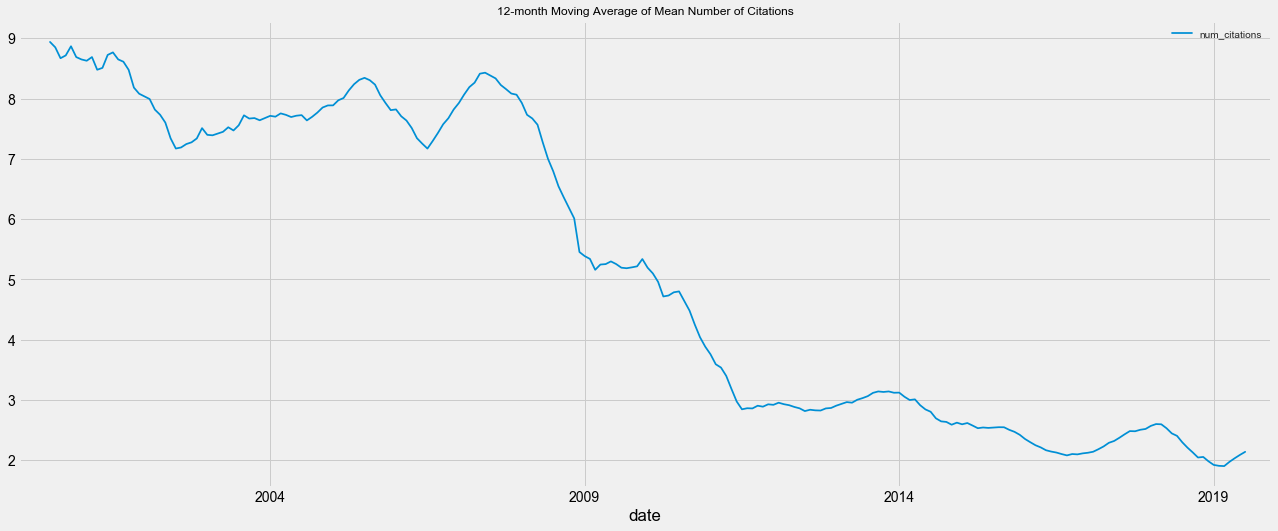

In [101]:
fig, ax = plt.subplots()
plt.style.use('seaborn')
mean_citations_monthly = pd.DataFrame(month_year_group['num_citations'].mean())
mean_citations_monthly.index = pd.to_datetime(mean_citations_monthly.index) 
mean_citations_monthly.sort_index(inplace=True) 
mean_citations_monthly.rolling(12, center=True).mean().plot(figsize=(20,8), ax=ax, title='12-month Moving Average of Mean Number of Citations')

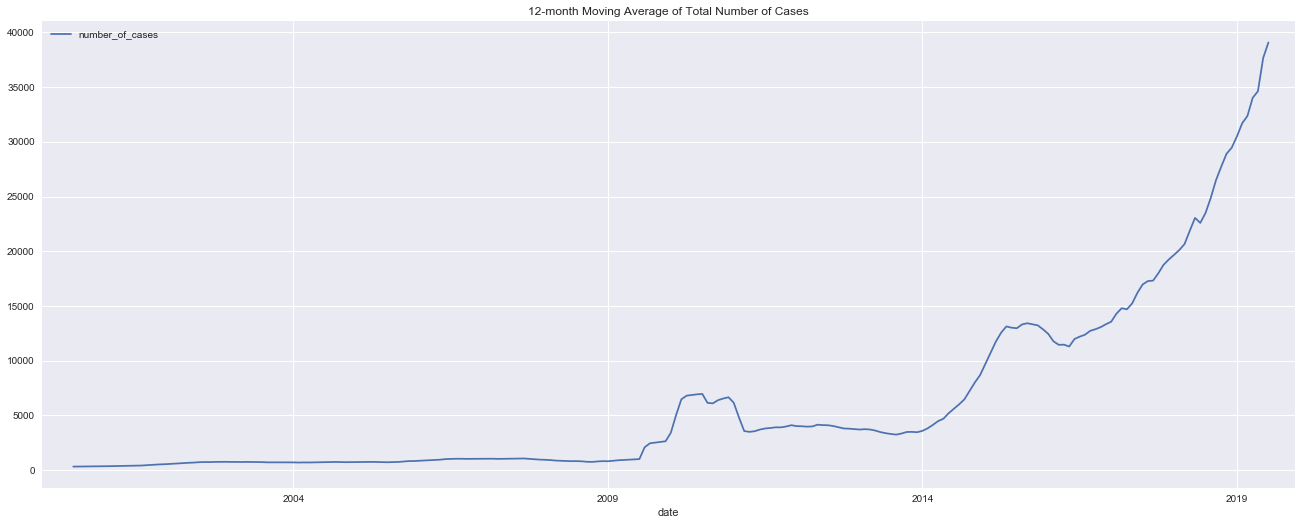

In [104]:
fig, ax = plt.subplots()
plt.style.use('seaborn')
cases_by_time = pd.DataFrame(month_year_group.size())
cases_by_time.index = pd.to_datetime(cases_by_time.index)
cases_by_time.sort_index(inplace=True) 
cases_by_time.columns = ['number_of_cases']
cases_by_time.rolling(12, center=True).mean().plot(figsize=(20,8), ax=ax, title='12-month Moving Average of Total Number of Cases')
# cases_by_time.plot(figsize=(20,8))

Text(0, 0.5, 'Mean Number of Citations per Case by Year')

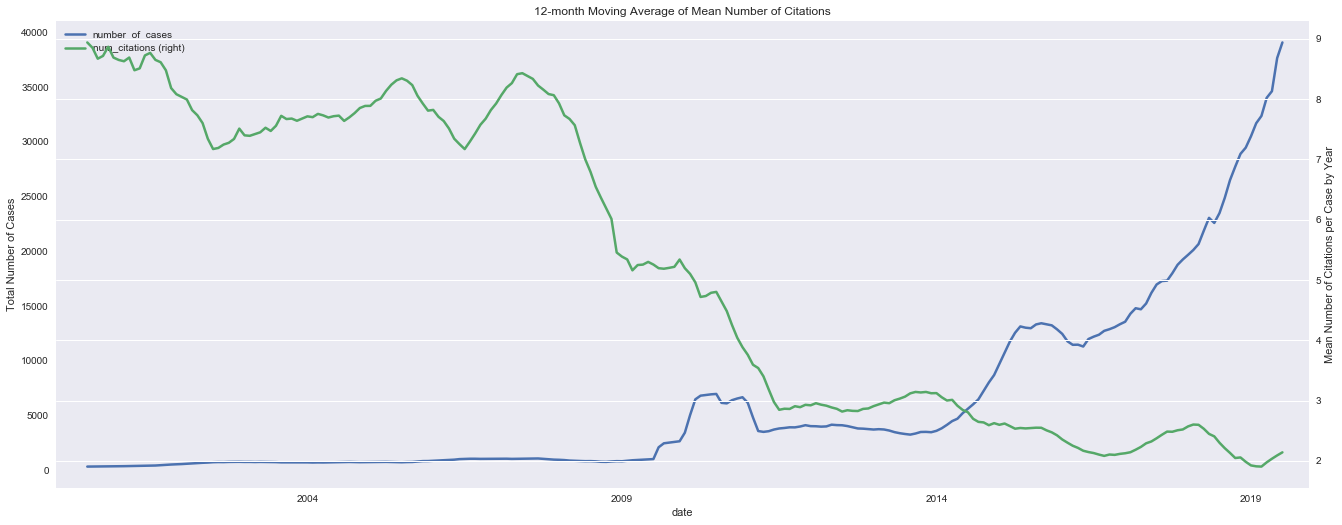

In [114]:
fig, ax = plt.subplots()
plt.style.use('seaborn')

cases_by_time.rolling(12, center=True).mean().plot(figsize=(20,8), linewidth=2.5, ax=ax, title='12-month Moving Average of Total Number of Cases')
ax.set_ylabel("Total Number of Cases")

mean_citations_monthly.rolling(12, center=True).mean().plot(figsize=(20,8), linewidth=2.5, secondary_y=True, ax=ax, title='12-month Moving Average of Mean Number of Citations')
plt.ylabel("Mean Number of Citations per Case by Year")

Text(0, 0.5, 'Mean number of citations per case')

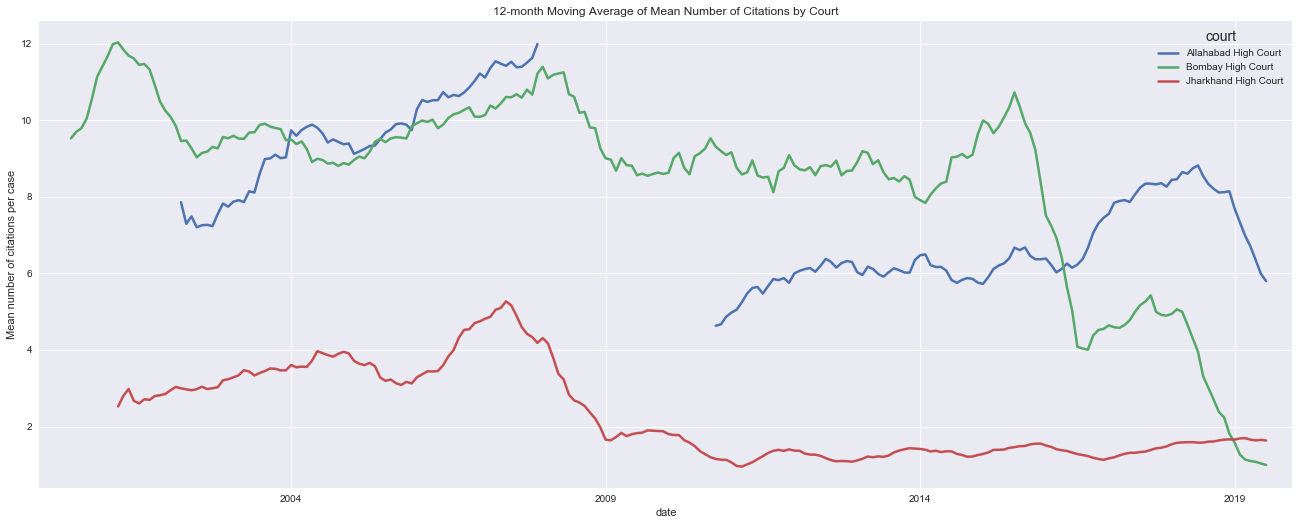

In [119]:
fig, ax = plt.subplots()
plt.style.use('seaborn')

citations_by_court_year = df[(df.court== 'Bombay High Court')|(df.court=='Jharkhand High Court')|(df.court=='Allahabad High Court')]
citations_by_court_year.index = pd.to_datetime(citations_by_court_year.date.dt.strftime('%B-%Y'), format='%B-%Y')
citations_by_court_year = citations_by_court_year.pivot_table(index = citations_by_court_year.index,columns='court',values='num_citations',aggfunc='mean')
citations_by_court_year = citations_by_court_year.rolling(12, center=True).mean()
citations_by_court_year.plot(figsize=(20,8), linewidth=2.5, ax=ax, title='12-month Moving Average of Mean Number of Citations by Court')
plt.ylabel("Mean number of citations per case")

Text(0, 0.5, 'Total Number of Cases')

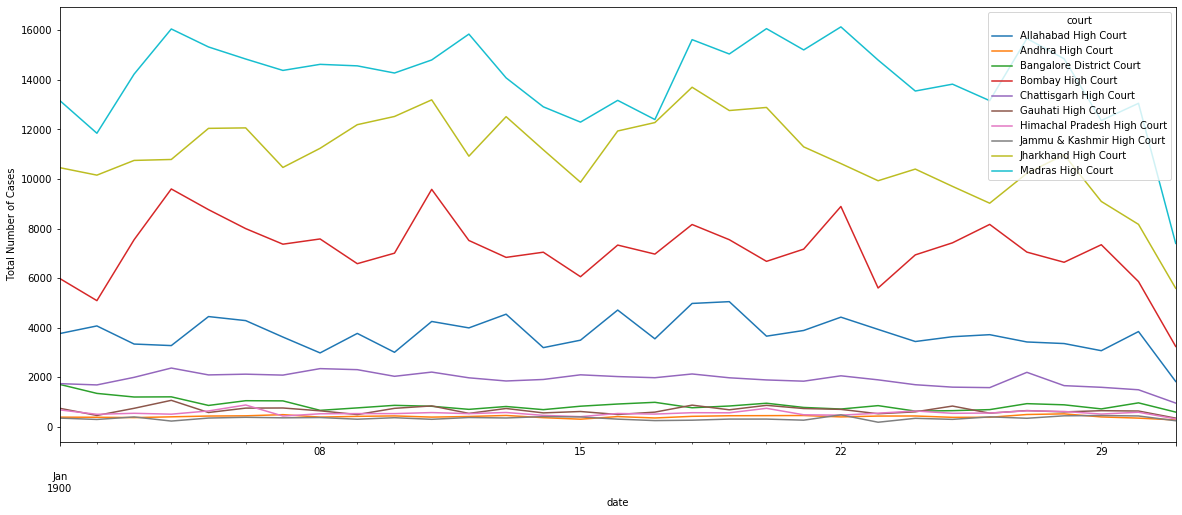

In [41]:
cases_by_court_year = df #[(df.court=='Bombay High Court')|(df.court=='Jharkhand High Court')|(df.court=='Allahabad High Court')]
cases_by_court_year.index = pd.to_datetime(cases_by_court_year.date.dt.strftime('%d'), format='%d')
plot3 = cases_by_court_year.pivot_table(index = cases_by_court_year.index,columns='court',values='num_citations',aggfunc='count').plot(figsize=(20,8))
plot3.set_ylabel("Total Number of Cases")

In [16]:
from textdistance import smith_waterman, needleman_wunsch, jaro_winkler, jaccard, levenshtein

judges_dict = defaultdict(int)
for judge_set in df['judge']:
    if str(judge_set)!='nan':
        for judge in judge_set:
            judges_dict[judge] += 1

In [17]:
print(len(judges_dict))        

for judge_pair in itertools.combinations(judges_dict, 2):
    score = jaccard.normalized_similarity(judge_pair[0], judge_pair[1])
    if score>0.95:
        carryover = judges_dict.pop(judge_pair[1], 0)
        judges_dict[judge_pair[0]] += carryover

print(len(judges_dict))

15415
13784


15415 entries trimmed to 13784 judges after merging similar key values above.

## Forward Citations
I think cases after 2009 were uploaded as they were put up online by the courts as Sushant I believe said he had a daily crawler. In that case we do not have a pre period to compare the pre vs post putting the case up on IK. What we could do instead is to check the pre vs post for cases before 2009 when IK did not exist. For these older cases we can check their average citations before IK and then after to see if there exists any jump. However, the problem here is the very small number of cases we have for years before 2009. 

In [138]:
pre2009cases = df[df.date.dt.year<2009].case_id.to_list()

for case in pre2009cases:
    for row in df.itertuples():
        print(row)
        break
    break

Pandas(Index=Timestamp('1900-01-16 00:00:00'), file='bombay/2000/1001219.txt', cnr_num=nan, title='Smt. Kamalabai Baburao Kabade vs Smt. Laxmibai Janardan Jagtap And ...', date=Timestamp('2000-06-16 00:00:00'), court='Bombay High Court', case_number=nan, petitioner=nan, respondent=nan, petitioner_advocate=nan, respondent_advocate=nan, judge={'A Khanwilkar'}, banks=nan, citations={'1331149', '135316600', '1108515', '26690152', '1630779', '1412634', '173132957'}, bench_size=1.0, num_citations=7.0, chief_justice=False, state=False, business=nan, case_id='1001219', times_cited=6)


In [73]:
sum(citation_counts.values())

1137181

## Citation Diversity

In [135]:
def citation_diversity(df):
    hhi_indices = []
    for year in range(2000, 2020):
        for month in range(1,13):
            citation_counts_year = list(hp.citation_count_dict(df.loc[(df.date.dt.year==year)&(df.date.dt.month==month), :]).values())
#             print((sorted(citation_counts_year, reverse=True)[:10]), sum(citation_counts_year))
            array_p_i = np.array(citation_counts_year)/sum(citation_counts_year)
            hhi = array_p_i * array_p_i * 10000
            hhi_indices.append(sum(hhi))
    return pd.DataFrame({'date': pd.date_range(start='2000/1/1', end='2019/12/1', freq='MS'), 'citation_diversity_index': hhi_indices})

citation_diversity_bombay = citation_diversity(df.loc[df.court=='Bombay High Court', :]) 
citation_diversity_bombay.set_index('date', inplace=True)
citation_diversity_bombay = citation_diversity_bombay.rolling(12, center=True).mean()
citation_diversity_bombay

,citation_diversity_index
date,
2000-01-01,NaN
2000-02-01,NaN
2000-03-01,NaN
2000-04-01,NaN
2000-05-01,NaN
...,...
2019-08-01,NaN
2019-09-01,NaN
2019-10-01,NaN


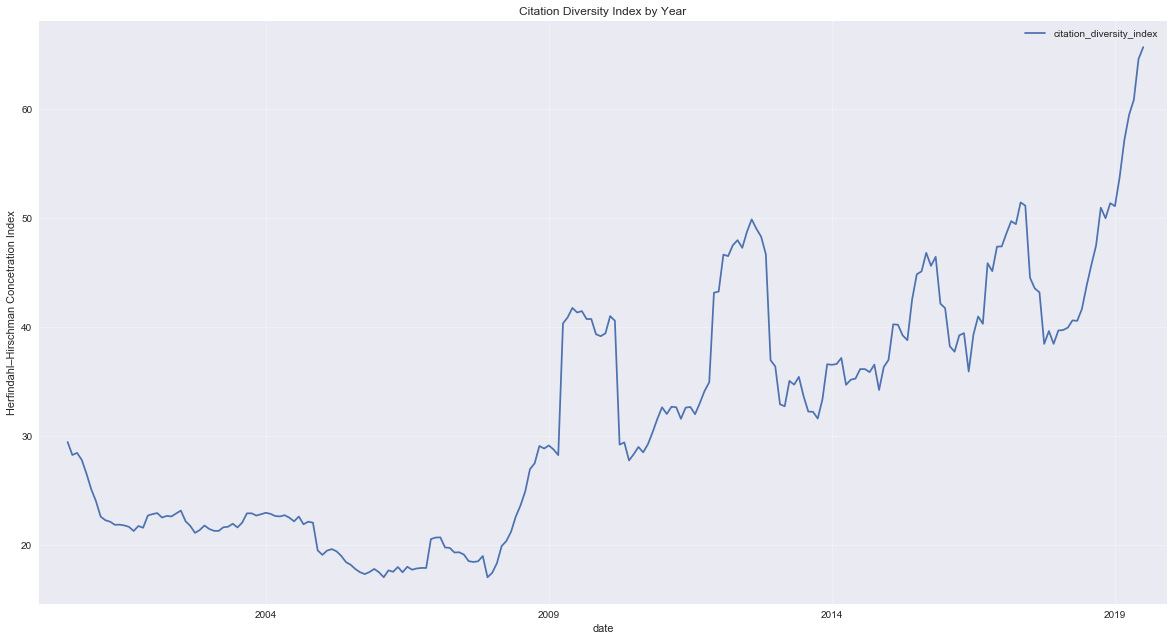

In [136]:
citation_diversity_bombay.index = pd.to_datetime(citation_diversity_bombay.index, format='%B-%Y')
fig, ax = plt.subplots()
citation_diversity_bombay.plot(figsize=(18,10), ax=ax, title='Citation Diversity Index by Year')
ax.set_ylabel('Herfindahl–Hirschman Concetration Index')
plt.grid(alpha=0.3)
plt.savefig('plot.png')

In [283]:
a = np.array([1, 3, 7, np.NaN])
np.sum(a)

nan

In [10]:

#df.groupby(
# df[df.date>"2000-01-01"] #.date.dt.strftime('%Y'))['num_citations'].mean()
sys.getsizeof(df)

4122469801

In [123]:
pd.date_range(start='2000/1/1', end='2019/12/1', freq='MS')

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', length=240, freq='MS')